In [1]:
import numpy as np
import torch
from src import kernel_flow, datagen

# generate dataset
Data = datagen.VDP(T=25, dt=0.0025,sigma=1.5,rho=0,N_sims=1)[0]
#train test split
observed_data= Data[0::2]
train_data = Data[:2000,:].T
test_data = Data[2000:,:].T
#times
Times = np.linspace(1,2000-1,2000-1)

# Some constants
nparameters=24
delay = 10
regu_lambda = 0.0001


# Get scaling factor
normalize=np.amax(train_data[:,:])

X_train, Y_train = datagen.prepare_data(train_data,delay,normalize)
X_test, Y_test = datagen.prepare_data(test_data,delay,normalize)


model = kernel_flow.KernelFlows("anl3",nparameters= 24, regu_lambda=regu_lambda)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

model.set_training_data(torch.Tensor(X_train).double(),torch.Tensor(Y_train).double())

for i in range(1000):
    optimizer.zero_grad()
    rho = model.forward()
    if rho>=0 and rho<=1:
        rho.backward()
        optimizer.step()
        print(rho)

print(model.kernel_params)

tensor(0.7571, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0042, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1710, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1722, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2310, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2361, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1525, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1448, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2585, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2508, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.3312, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1929, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1478, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2503, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1770, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.3315, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1685, dtype=tor

tensor(0.2006, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1914, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2710, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2056, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1676, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1910, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2951, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1958, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2371, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2405, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.3861, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2864, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2282, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1613, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1763, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2352, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2100, dtype=tor

tensor(0.2295, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.3320, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2149, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1899, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2189, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.3125, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2332, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1444, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2850, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1728, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2186, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1955, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2755, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1819, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2183, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2470, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1899, dtype=tor

tensor(0.2586, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2586, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2703, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2693, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2956, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1423, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2253, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2009, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.3022, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2646, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2427, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1497, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.3101, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2477, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1813, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1839, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1474, dtype=tor

tensor(0.1849, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2060, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2849, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2538, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2770, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2334, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1194, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2326, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2089, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1876, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2771, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2327, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1955, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2509, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2257, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1920, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2083, dtype=tor

tensor(0.2842, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1349, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2221, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2297, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2784, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.3068, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2577, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1810, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2009, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2338, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.3377, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2267, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2074, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2092, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2318, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1957, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2088, dtype=tor

tensor(0.2654, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1783, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.3601, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2633, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2905, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1736, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1576, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1865, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1696, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2836, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1920, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2670, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2854, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1656, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2406, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2160, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1777, dtype=tor

tensor(0.3390, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1844, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2497, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2409, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2989, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2114, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1851, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2416, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1824, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.3156, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1795, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2125, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1626, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1478, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2018, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1247, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2862, dtype=tor

In [2]:
model.compute_kernel_and_inverse(regu_lambda = regu_lambda)
Y_pred = model.predict(torch.Tensor(X_test).double())

In [3]:
(Y_pred.detach()-Y_test).pow(2).mean()

tensor(0.0085, dtype=torch.float64)

Text(0, 0.5, 'y')

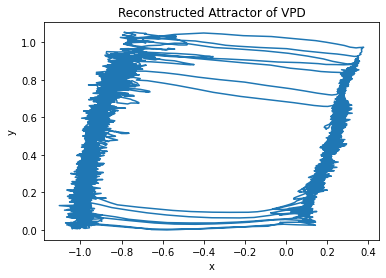

In [4]:
import matplotlib.pyplot as plt
plt.plot(Y_pred[:,0].detach(),Y_pred[:,10].detach())
plt.title("Reconstructed Attractor of VPD")
plt.xlabel("x")
plt.ylabel("y")

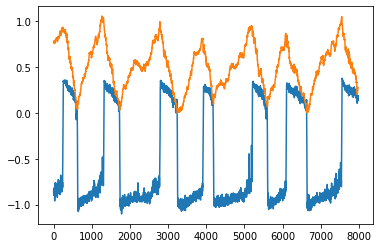

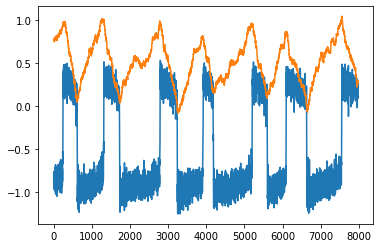

In [5]:
plt.plot(Y_pred[:,(0,10)].detach())
plt.figure()
plt.plot(Y_test[:,(0,10)])